The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image  qϕ(z|xi)

and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector  pθ(x|z)

Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy.

VAE PAPER

https://arxiv.org/pdf/1312.6114.pdf

In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from  torchvision.datasets import MNIST

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt


In [3]:
latent_dimensions=2 #2d latent space
number_epochs=100
bs=128
capacity=64
learning_rate=1e-3
var_beta=1

In [4]:
transformations=transforms.Compose([transforms.ToTensor()])

In [5]:
train_data=MNIST(root='./data/MNIST',download=True,
                 train=True,transform=transformations)

test_data=MNIST(root='./data/MNIST',download=True,
               train=False,transform=transformations)

In [6]:
train_dataloader=DataLoader(train_data,batch_size=bs,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=bs,shuffle=True)

In [7]:
def get_gpu_details():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    print(torch.cuda.get_device_name())
    print(f'Total GPU Memory {t} B , Cached GPU Memory {c} B, Allocated GPU Memory {a} B')

In [8]:
if torch.cuda.is_available():
    device='cuda:0'
else:
    device='cpu'
print(f'Current Device: {device}')
if device=='cuda:0':
    torch.cuda.empty_cache()
    get_gpu_details()

Current Device: cuda:0
GeForce RTX 2060
Total GPU Memory 6442450944 B , Cached GPU Memory 0 B, Allocated GPU Memory 0 B


# variational autoencoder

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        num_channels=capacity
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=num_channels,kernel_size=4,stride=2,padding=1)
        # conv1= #channels x 14 x 14
        
        self.conv2=nn.Conv2d(in_channels=num_channels,out_channels=num_channels*2,kernel_size=4,stride=2,padding=1)
        # conv2= #channels x 7 x 7
        
        #latent dimension parameters
        
        self.mean_layer=nn.Linear(in_features=num_channels*2*7*7,out_features=latent_dimensions)
        self.logvar_layer=nn.Linear(in_features=num_channels*2*7*7,out_features=latent_dimensions)
        
        
        
        
    def forward(self,inp):
        out1=f.relu(self.conv1(inp))
        out2=f.relu(self.conv2(out1))
        
        #flatten to input to latent dim layer
        out2=out2.view(out2.size(0),-1)
        
        mean=self.mean_layer(out2)
        log_variance=self.logvar_layer(out2)
        
        return mean,log_variance

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        num_channels=capacity
        
        self.fc_layer=nn.Linear(in_features=latent_dimensions,out_features=num_channels*2*7*7)
        
        self.deconv1=nn.ConvTranspose2d(in_channels=num_channels*2,out_channels=num_channels,kernel_size=4,stride=2,padding=1)
        self.deconv2=nn.ConvTranspose2d(in_channels=num_channels,out_channels=1,kernel_size=4,stride=2,padding=1)
        
        
    def forward(self,inp):
        out=self.fc_layer(inp)
        #unflatten
        out=out.view(out.size(0),capacity*2,7,7)
        
        out1=f.relu(self.deconv1(out))
        out2=torch.sigmoid(self.deconv2(out1))
        
        return out2

In [11]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder_block=Encoder()
        self.decoder_block=Decoder()
    
    def forward(self,inp):
        latent_mean,latent_logvar=self.encoder_block(inp)
        latent_sample=self.generate_latent_sample(latent_mean,latent_logvar)
        reconstructed_inp=self.decoder_block(latent_sample)
        return reconstructed_inp,latent_mean,latent_logvar
    
        
    def generate_latent_sample(self,mean,logvar):
        #reparameterization trick
        if self.training:
            standard_dev=logvar.mul(0.5).exp_()
            gaussian_noise_eps=torch.empty_like(standard_dev).normal_()
            return gaussian_noise_eps.mul(standard_dev).add_(mean) #mu+sigma.eps
        else:
            return mean
        
        

1.     reconstructed_x is the probability of a multivariate Bernoulli distribution p.
2.    -log(p(x)) is then the pixel-wise binary cross-entropy.
3.    Averaging or not averaging the binary cross-entropy over all pixels here
4.    is a subtle detail with big effect on training, since it changes the weight
5.   we need to pick for the other loss term by several orders of magnitude.
6.   Not averaging is the direct implementation of the negative log likelihood,
7.   but averaging makes the weight of the other loss term independent of the image resolution.

<img src="variational_kld_loss.png" width="800" height="400">

In [12]:
def variational_encoder_loss(reconstructed_inp,inp,mean,logvar):
    reconstruction_loss=f.binary_cross_entropy(reconstructed_inp.view(-1,784),
                                              inp.view(-1,784),reduction='sum')
    
    kl_divergence=-0.5 * torch.sum(1+logvar - mean.pow(2) - logvar.exp())
    
    return reconstruction_loss +  var_beta * kl_divergence

In [13]:
vae_model=VAE()
vae_model=vae_model.to(device)

In [14]:
get_gpu_details()

GeForce RTX 2060
Total GPU Memory 6442450944 B , Cached GPU Memory 2097152 B, Allocated GPU Memory 1235456 B


In [15]:
number_of_parameters=sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters {number_of_parameters}.')

Number of trainable parameters 308357.


In [16]:
def train_model(vae_model,optimizer,num_epochs):
    average_training_loss=[]
    
    for epoch in range(num_epochs):
        average_training_loss.append(0)
        num_batches=0
        
        for mini_batch,_ in train_dataloader:
            mini_batch=mini_batch.to(device)
            
            
            #reconstruction
            reconstructed_mini_batch,latent_mean,latent_logvar=vae_model(mini_batch)
            
            #reconstruction_loss
            reconstruction_loss=variational_encoder_loss(reconstructed_mini_batch,mini_batch,
                                                         latent_mean,latent_logvar)
            
            #backprop
            optimizer.zero_grad()
            reconstruction_loss.backward()
            
            optimizer.step()
            
            average_training_loss[-1]+=reconstruction_loss.item()
            num_batches+=1
            
        average_training_loss[-1]/=num_batches   
        print(f'Epoch [{epoch}/{num_epochs}] average reconstruction_error : {average_training_loss[-1]}')
    
    return average_training_loss,vae_model

In [17]:
%%time
optimizer=torch.optim.Adam(params=vae_model.parameters(),
                           lr=learning_rate,weight_decay=1e-5)

vae_model.train()
average_training_loss,vae_model=train_model(vae_model,optimizer,num_epochs=100)

Epoch [0/100] average reconstruction_error : 23216.762172674575
Epoch [1/100] average reconstruction_error : 21020.424773454157
Epoch [2/100] average reconstruction_error : 20471.047939015858
Epoch [3/100] average reconstruction_error : 20202.80274895056
Epoch [4/100] average reconstruction_error : 20038.43240271855
Epoch [5/100] average reconstruction_error : 19903.95040145256
Epoch [6/100] average reconstruction_error : 19802.812737373402
Epoch [7/100] average reconstruction_error : 19717.91631962953
Epoch [8/100] average reconstruction_error : 19644.63436583822
Epoch [9/100] average reconstruction_error : 19590.11012876466
Epoch [10/100] average reconstruction_error : 19532.34544492937
Epoch [11/100] average reconstruction_error : 19485.605814398987
Epoch [12/100] average reconstruction_error : 19446.358425506398
Epoch [13/100] average reconstruction_error : 19402.563453658047
Epoch [14/100] average reconstruction_error : 19376.363537363406
Epoch [15/100] average reconstruction_erro

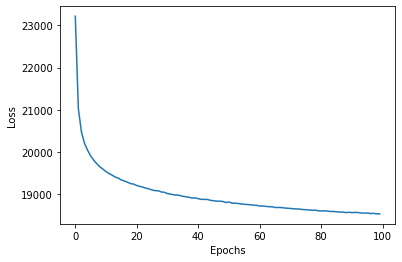

In [18]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(average_training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
def evaluate_model(vae_model):
    average_test_loss, num_batches = 0, 0
    for image_batch, _ in test_dataloader:

        with torch.no_grad():

            image_batch = image_batch.to(device)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae_model(image_batch)

            # reconstruction error
            loss = variational_encoder_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            average_test_loss += loss.item()
            num_batches += 1

    average_test_loss /= num_batches
    print('average reconstruction error: %f' % (average_test_loss))

In [23]:
vae_model.eval()
evaluate_model(vae_model)

average reconstruction error: 19077.512244


Original images


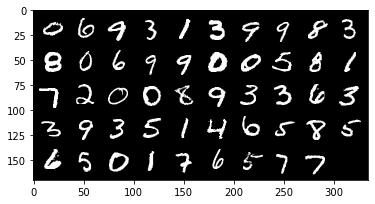

VAE reconstruction:


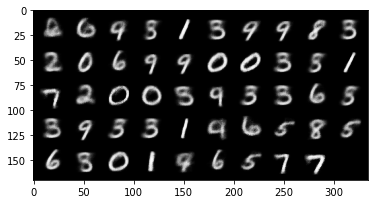

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae_model.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_model)

# experiment with different latent spaces

In [31]:
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder_block(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder_block(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder_block(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    

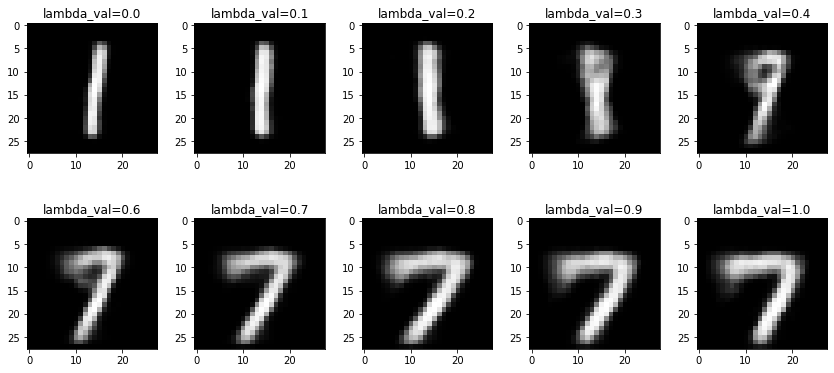

In [32]:
vae_model.eval()

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae_model, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 